In [70]:
!pip install emoji
!pip install langdetect

In [71]:
# Import Library yg dibutuhkan


from textwrap import wrap

import emoji
import joblib
import langdetect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

plt.style.use("fivethirtyeight")
warnings.filterwarnings("ignore")


In [72]:
def get_category_dict(category_file):
    category = pd.read_json(category_file, orient="records")
    category = pd.DataFrame(category["items"].values.tolist())

    return {
        cat.id: cat.snippet.get("title")
        for cat in category.itertuples(index=False)
    }


In [73]:
def get_category_dict(category_file):
    category = pd.read_json(category_file, orient="records")
    category = pd.DataFrame(category["items"].values.tolist())

    return {
        cat.id: cat.snippet.get("title")
        for cat in category.itertuples(index=False)
    }


In [74]:
category_dict = get_category_dict("/content/drive/MyDrive/category.json")


In [75]:
trending = pd.read_csv("/content/drive/MyDrive/trending.csv", parse_dates=["publish_time", "trending_time"])

with pd.option_context("display.max_columns", None):
    display(trending.head())


,video_id,publish_time,channel_id,title,description,thumbnail_url,thumbnail_width,thumbnail_height,channel_name,tags,category_id,live_status,local_title,local_description,duration,dimension,definition,caption,license_status,allowed_region,blocked_region,view,like,dislike,favorite,comment,trending_time
0,NaN,2021-02-05 09:00:34+00:00,UCEf_Bc-KVd7onSeifS3py9g,aespa 에스파 'Forever (약속)' MV,"aespa's new single ""Forever"" is out!\nListen a...",NaN,NaN,NaN,SMTOWN,NaN,10,none,aespa 에스파 'Forever (약속)' MV,"aespa's new single ""Forever"" is out!\nListen a...",PT5M7S,2d,hd,True,True,NaN,NaN,7806846.0,857902.0,24078.0,0,94961.0,2021-02-07 05:46:51.832614+00:00
1,NaN,2021-02-04 15:54:08+00:00,UCYEa4_MC7OFjcWrO6SO-u8g,[FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...,"Jakarta, https://www.tvonenews.com - Ketua umu...",NaN,NaN,NaN,Indonesia Lawyers Club,"['tvone', 'tv one', 'tvonenews', 'indonesia la...",25,none,[FULL] Siapa di Balik Kudeta AHY? | Dua Sisi t...,"Jakarta, https://www.tvonenews.com - Ketua umu...",PT42M30S,2d,hd,False,True,NaN,NaN,885038.0,6765.0,1263.0,0,6365.0,2021-02-07 05:46:51.832649+00:00
2,NaN,2021-02-06 03:00:22+00:00,UCu12RxQjRQyh79YBYvEDkOg,CABRIOLET CHALLENGE: TANTANGAN MENGGODA (7/12),Road Party Season 2: Cabriolet Challenge\n\nEp...,NaN,NaN,NaN,Motomobi,"['MotoMobi', 'Mobil', 'motor', 'review', 'indo...",2,none,CABRIOLET CHALLENGE: TANTANGAN MENGGODA (7/12),Road Party Season 2: Cabriolet Challenge\n\nEp...,PT46M43S,2d,hd,False,True,NaN,NaN,889708.0,47895.0,532.0,0,8785.0,2021-02-07 05:46:51.832664+00:00
3,NaN,2021-02-05 20:26:08+00:00,UCCuzDCoI3EUOo_nhCj4noSw,With Windah Basudara & Hans,Join this channel to get access to perks:\nhtt...,NaN,NaN,NaN,yb,NaN,20,none,With Windah Basudara & Hans,Join this channel to get access to perks:\nhtt...,PT45M59S,2d,hd,False,True,NaN,NaN,1006854.0,91973.0,3967.0,0,12957.0,2021-02-07 05:46:51.832678+00:00
4,NaN,2021-02-03 23:14:54+00:00,UC14UlmYlSNiQCBe9Eookf_A,🤯 LATE COMEBACK DRAMA! | HIGHLIGHTS | Granada ...,"With just two minutes to play, Barça looked to...",NaN,NaN,NaN,FC Barcelona,"['FC Barcelona', 'برشلونة،', 'Fútbol', 'FUTBOL...",17,none,🤯 LATE COMEBACK DRAMA! | HIGHLIGHTS | Granada ...,"With just two minutes to play, Barça looked to...",PT5M12S,2d,hd,False,True,NaN,NaN,6275035.0,218131.0,4289.0,0,12799.0,2021-02-07 05:46:51.832730+00:00


In [76]:
start_date = trending.trending_time.min()
end_date = trending.trending_time.max()

print(f"start_date = {start_date}")
print(f"end_date = {end_date}")


start_date = 2021-02-07 05:46:51.832614+00:00
end_date = 2023-09-01 09:16:49.916211+00:00


In [77]:
trending['trending_time'] = pd.to_datetime(trending['trending_time'], format='mixed')


In [78]:
# Delete data dari bulan Februari - Juni

# Convert 'trending_time' to datetime if it's not already
trending['trending_time'] = pd.to_datetime(trending['trending_time'])

filtered_trending = trending[trending.trending_time.dt.month >= 7]

start_date = filtered_trending.trending_time.min()
end_date = filtered_trending.trending_time.max()

print(f"{start_date = }")
print(f"{end_date = }")

start_date = Timestamp('2021-07-01 06:01:25.524449+0000', tz='UTC')
end_date = Timestamp('2023-09-01 09:16:49.916211+0000', tz='UTC')


In [79]:
num_videos = filtered_trending.shape[0]
print(f"num_videos = {num_videos}")


num_videos = 81517


In [80]:
# Distribusi Missing Value

filtered_trending.info()


<class 'pandas.core.frame.DataFrame'>
Index: 81517 entries, 21322 to 172346
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   video_id           49717 non-null  object             
 1   publish_time       81517 non-null  datetime64[ns, UTC]
 2   channel_id         81517 non-null  object             
 3   title              81517 non-null  object             
 4   description        78544 non-null  object             
 5   thumbnail_url      49717 non-null  object             
 6   thumbnail_width    49717 non-null  float64            
 7   thumbnail_height   49717 non-null  float64            
 8   channel_name       81517 non-null  object             
 9   tags               70149 non-null  object             
 10  category_id        81517 non-null  int64              
 11  live_status        81517 non-null  object             
 12  local_title        81517 non-null  object     

In [81]:
# Delete video dengan description kosong

filtered_trending.dropna(subset=["description"], inplace=True)


In [82]:
trending_by_date = filtered_trending.groupby(
    filtered_trending.trending_time.dt.date
)

num_trending_per_day = trending_by_date.trending_time.count()

print("Number of videos in trending per day:", num_trending_per_day.unique())


Number of videos in trending per day: [195 196 197 198 194 193 192 191 190 188 187 185 189 186 184 183 132 182
 181 179 176 172 155 144 149 148 141 140 131 129 145 167 163 157 156 175
 169 199 200 381]


In [83]:
trending_duration = filtered_trending.groupby("title").agg(
    trending_duration=pd.NamedAgg(column="trending_time", aggfunc="count"),
    trending_start_date=pd.NamedAgg(column="trending_time", aggfunc="min"),
    trending_last_date=pd.NamedAgg(column="trending_time", aggfunc="max")
).sort_values("trending_duration", ascending=False).reset_index()

# Menambahkan kolom jumlah hari video bertahan di trending
trending_duration["days_trending"] = (
    trending_duration["trending_last_date"] - trending_duration["trending_start_date"]
).dt.days

# Menampilkan 10 video dengan durasi trending terlama
trending_duration.head(10)

,title,trending_duration,trending_start_date,trending_last_date,days_trending
0,Toleransi antar tetangga di Korea🇰🇷.. 🤦🏻‍♂️,37,2022-07-02 06:01:31.621606+00:00,2022-08-07 06:01:00.607651+00:00,35
1,"JEJE PENGHUNI STASIUN DUKUH ATAS, PERNAH CABUT...",37,2022-07-02 06:01:31.621150+00:00,2022-08-07 06:01:00.607537+00:00,35
2,"NEGO 1 GEROBAK SHAWARMA VIRAL DI TIKTOK, SAMPE...",36,2022-07-08 06:01:39.900318+00:00,2022-08-12 06:01:33.892049+00:00,34
3,OPW ARES Sudah Tamat,35,2022-07-02 06:01:31.621296+00:00,2022-08-05 06:02:43.644196+00:00,34
4,"Tantangin VYN Pake Franco, 1 Kali Kena Hook Da...",35,2022-07-01 06:01:38.284040+00:00,2022-08-04 06:02:04.519603+00:00,34
5,SINGAPORE STREET FOOD #08,35,2022-07-02 06:01:31.621620+00:00,2022-08-06 06:02:02.694750+00:00,35
6,Kok di Indonesia ada penjual Rawon yg lebih pi...,34,2022-07-02 06:01:31.621592+00:00,2022-08-04 06:02:04.519738+00:00,33
7,SELAMAT LEBARAN GUYS!!!,33,2022-07-11 06:00:59.413948+00:00,2022-08-12 06:01:33.891919+00:00,32
8,"HANYA FARIDA NURHAN, MUKBANG MIE GACOAN LEVEL ...",32,2022-07-11 06:00:59.414152+00:00,2022-08-11 06:01:46.801212+00:00,31
9,BORONG ISI KULKAS SAMA BABY SHARK!!!,32,2022-07-02 06:01:31.621266+00:00,2022-08-02 06:14:40.735514+00:00,31


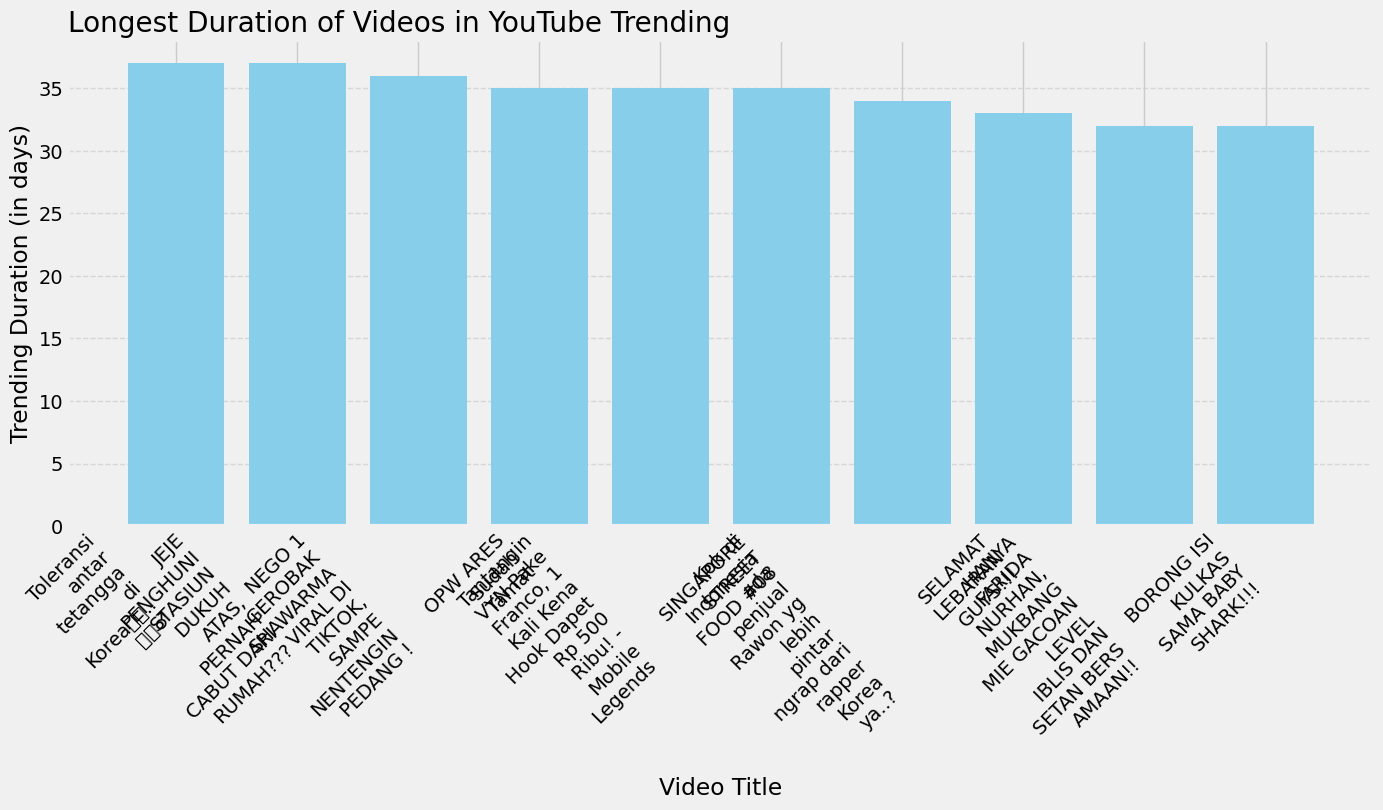

In [84]:
import matplotlib.pyplot as plt
import textwrap

# Visualisasi data trending dengan chart bar
plt.figure(figsize=(15, 6))
plt.bar(
    trending_duration.title[:10].apply(lambda title: "\n".join(textwrap.wrap(title, width=10))),
    trending_duration.trending_duration[:10], color='skyblue'
)

plt.title("Longest Duration of Videos in YouTube Trending", loc="left")
plt.xlabel("Video Title")
plt.ylabel("Trending Duration (in days)")
plt.xticks(rotation=45, ha="right")  # Memutar label agar lebih mudah dibaca
plt.grid(axis='y', linestyle="--", alpha=0.7)  # Menambah grid untuk memudahkan analisis
plt.show()


In [85]:
trending_by_title = filtered_trending.groupby("title")
trending_rewind = trending_by_title[['view', 'like', 'dislike']].agg(["min", "max", "mean", "sum"])
trending_rewind


view             \
                                                          min        max   
title                                                                      
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...   101823.0   121044.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2280620.0  2637486.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    72434.0   116310.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."        1798947.0  2064042.0   
"Grebek rumah harris vriza, dan percintaannya d...    68879.0   163773.0   
...                                                       ...        ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   148668.0   680210.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...   330156.0  7334655.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...   278942.0  1212522.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...   320084.0  1097903.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  1423178.0  2966798.0   

                                                                              \
                                                            mean         sum   
title                                                                          
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...  1.114335e+05    222867.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...  2.459053e+06   4918106.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...  9.390625e+04    375625.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."        1.981122e+06  19811225.0   
"Grebek rumah harris vriza, dan percintaannya d...  1.267565e+05    760539.0   
...                                                          ...         ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...  5.519997e+05   8831995.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...  3.414214e+06  34142143.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...  7.948737e+05   5564116.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...  7.562497e+05   4537498.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  2.629831e+06  36817634.0   

                                                        like            \
                                                         min       max   
title                                                                    
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...    1336.0    1456.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   93348.0  101207.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...     990.0    1432.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."         41528.0   44699.0   
"Grebek rumah harris vriza, dan percintaannya d...    5529.0    8714.0   
...                                                      ...       ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   39847.0  101922.0   
🥰 New Gadgets & Versatile Utensils For Home # 2...    2822.0   58066.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...    2790.0   10212.0   
🥰 New Gadgets & Versatile Utensils For Home # 3...    3025.0    8759.0   
🩸괴담회에 어서오세요🩸: 첫 번째 이야기 | WELCOME TO NCT’S HORRO...  316849.0  457809.0   

                                                                              \
                                                             mean        sum   
title                                                                          
"Awalnya Diserang Bertubi tubi" Lihatlah Bagaim...    1396.000000     2792.0   
"BABY R" BIKIN GEMES !!! RAFATHAR CEMBURU, SEMU...   97277.500000   194555.0   
"Emosi Rico Simanjutak" Saat Taisei Marukawa Be...    1228.500000     4914.0   
"GUE JADI TAU ISI HATI WARISO SELAMA INI..."         43795.800000   437958.0   
"Grebek rumah harris vriza, dan percintaannya d...    7486.833333    44921.0   
...                                                           ...        ...   
🥘Yuk! Kita coba in! Let’s eat | WayV’s ONE-DAY ...   87227.125000  1395634.0   
🥰 New Gadgets & Versatile Utensils

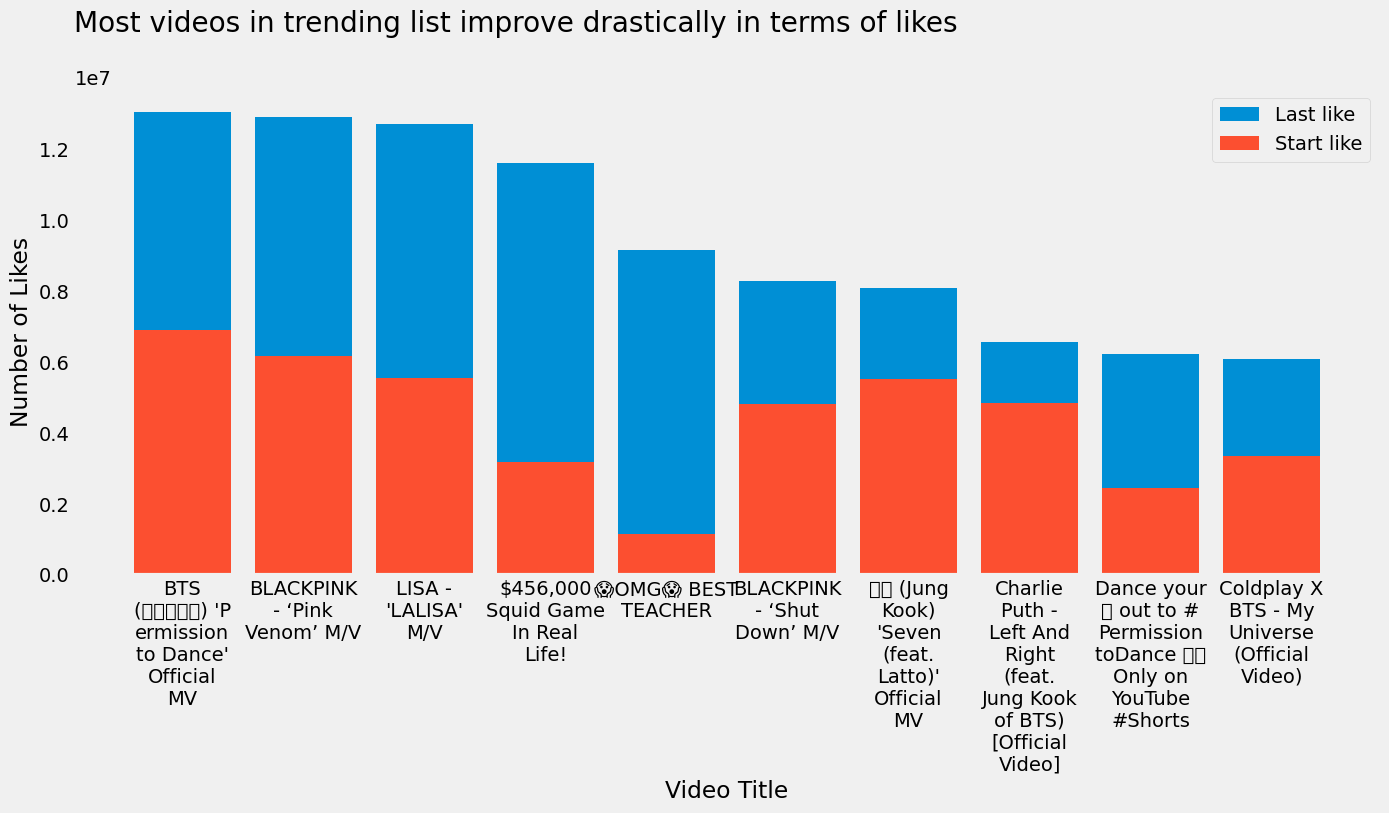

In [86]:
# Visualisasi Trending video teratas masing-masing berdasarkan jumlah like

top_10_liked = trending_rewind["like"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15, 6))

# Bar chart untuk jumlah like maksimal
plt.bar(
    top_10_liked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_liked["max"],
    label="Last like"
)

# Bar chart untuk jumlah like minimal
plt.bar(
    top_10_liked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_liked["min"],
    label="Start like"
)

plt.title("Most videos in trending list improve drastically in terms of likes", loc="left", y=1.1)
plt.xlabel("Video Title")
plt.ylabel("Number of Likes")
plt.legend()
plt.grid(False)
plt.show()


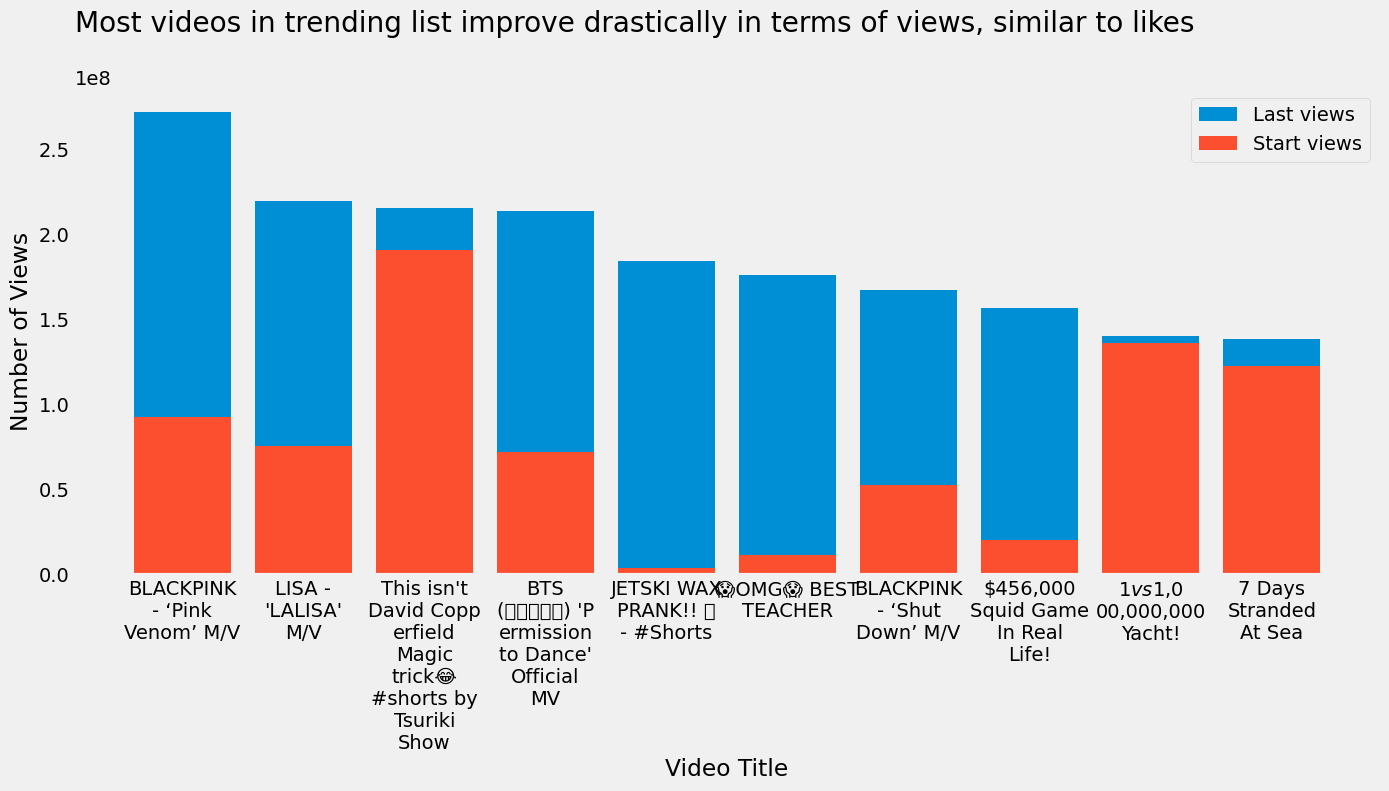

In [87]:
from textwrap import wrap
import matplotlib.pyplot as plt

# Mengambil 10 video dengan jumlah views tertinggi berdasarkan nilai maksimum
top_10_viewed = trending_rewind["view"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15, 6))

# Bar chart untuk jumlah view maksimum
plt.bar(
    top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_viewed["max"],
    label="Last views"
)

# Bar chart untuk jumlah view minimum
plt.bar(
    top_10_viewed.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_viewed["min"],
    label="Start views"
)

plt.title("Most videos in trending list improve drastically in terms of views, similar to likes", loc="left", y=1.1)
plt.xlabel("Video Title")
plt.ylabel("Number of Views")
plt.legend()
plt.grid(False)
plt.show()


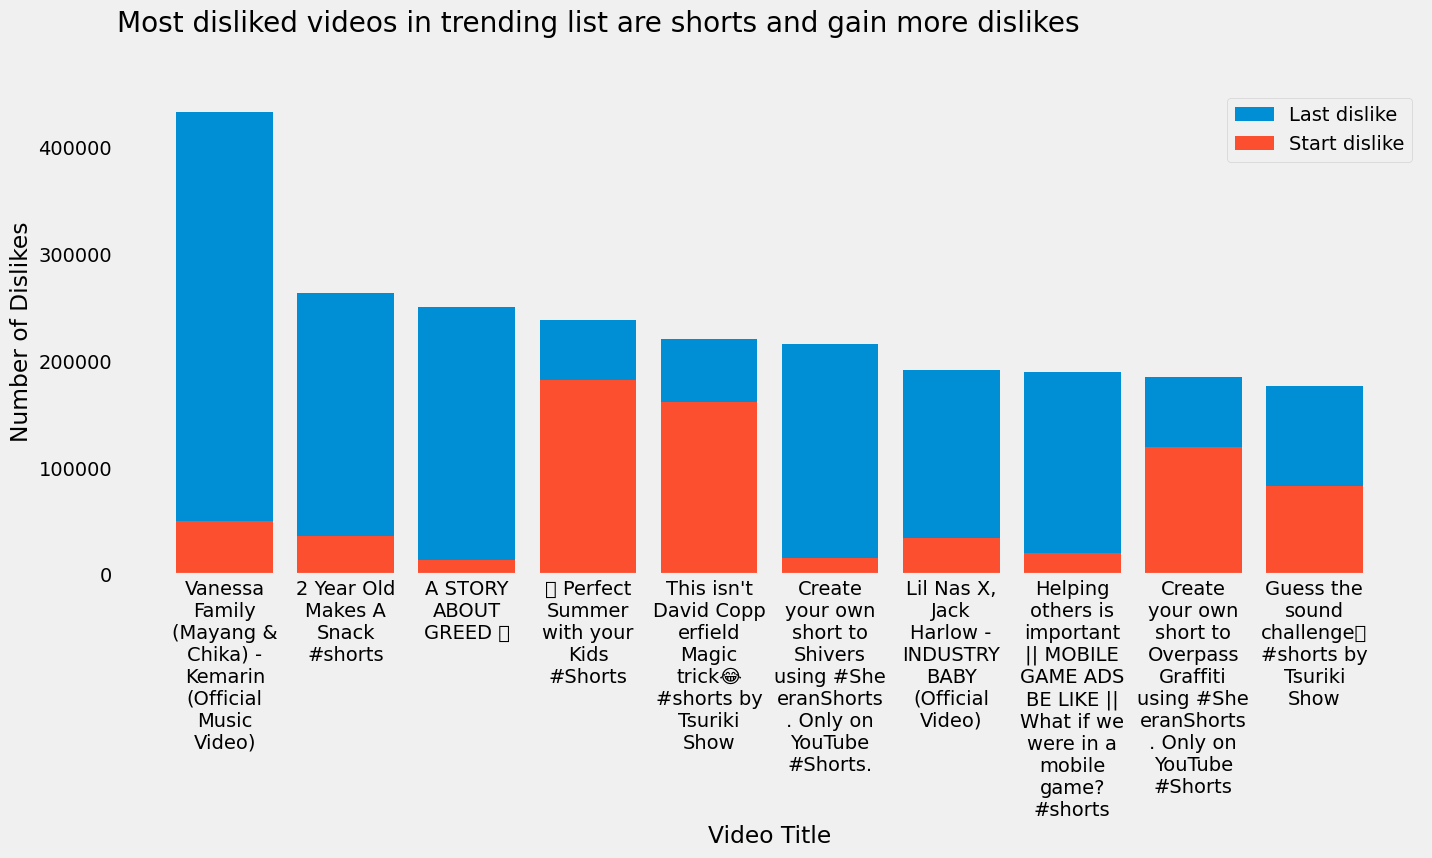

In [88]:
from textwrap import wrap
import matplotlib.pyplot as plt

# Mengambil 10 video dengan jumlah dislike tertinggi berdasarkan nilai maksimum
top_10_disliked = trending_rewind["dislike"].sort_values("max", ascending=False).iloc[:10]

plt.figure(figsize=(15, 6))

# Bar chart untuk jumlah dislike maksimum
plt.bar(
    top_10_disliked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_disliked["max"],
    label="Last dislike"
)

# Bar chart untuk jumlah dislike minimum
plt.bar(
    top_10_disliked.index.to_series().apply(lambda title: "\n".join(wrap(title, width=10))),
    top_10_disliked["min"],
    label="Start dislike"
)

plt.title("Most disliked videos in trending list are shorts and gain more dislikes", loc="left", y=1.1)
plt.xlabel("Video Title")
plt.ylabel("Number of Dislikes")
plt.legend()
plt.grid(False)
plt.show()


In [89]:
# Sebagai contoh, perhatikan sampel judul dan deskripsi video berikut.

sample = filtered_trending.sample(10, random_state=11)
sample[["title", "description"]]


,title,description
46742,CHALLENGE MAKAN PALING HORROR! #MakanOnlineCha...,MAKAN ONLINE CHALLENGE by MAKAN ONLINE\n\nSpon...
109477,The Pangeran and Justin Show: Badmin Son Hat-t...,Son Heung-min bikin langsung bikin hattrick se...
123855,Match Highlights Persik 0 - 3 PERSIB | Pekan 1...,PERSIB meraih kemenangan 3-0 atas Persik Kedir...
32257,MASTERCHEF INDONESIA - JADI PESERTA PERTAMA YG...,Galeri 19 | Part 7\n==========================...
29932,(COVER) Andekhi Anjaani - Putri Isnari feat Ri...,(COVER)Andekhi Anjaani - Putri Isnari feat Rid...
95923,Mira Putri ft Ageng Music - TIARA (Official Li...,Official Live Music : Mira Putri ft Ageng Musi...
121702,JKT48 New Era Special Performance Video – Eure...,Eureka Milik Kita hadir dengan konsep yang ber...
43837,RACHEL VENNYA DI BACK UP SIAPA⁉️ KITA BONGKAR ...,#rachelvennya #covid #podcast
115628,KIKY SAPUTRI DILAMAR ANAK PEJABAT,Silakan komen di bawah 🖤 Kalian mau aku buat k...
46159,Yeni Inka - Top Topan (Official Music Video AN...,Title: Top Topan\nArtist: Yeni Inka\nSongwrite...


In [90]:
# Merubah title dan deskripsi video menjadi lowercase

sample["title_lang"] = sample.title.apply(lambda title: langdetect.detect(title.lower()))
sample["desc_lang"] = sample.description.apply(lambda desc: langdetect.detect(desc.lower()))


In [91]:
with pd.option_context("display.max_colwidth", 100):
    display(sample[["title", "title_lang", "description", "desc_lang"]])


,title,title_lang,description,desc_lang
46742,CHALLENGE MAKAN PALING HORROR! #MakanOnlineChallenge (2/8),tl,MAKAN ONLINE CHALLENGE by MAKAN ONLINE\n\nSponsored by MS Slim by Ms Glow\n\nCHALLENGE FOOD VLOG...,en
109477,"The Pangeran and Justin Show: Badmin Son Hat-trick, Koci Gak Terkesan!",en,Son Heung-min bikin langsung bikin hattrick setelah gak mencetak gol di 8 pertandingan. Tapi Coa...,id
123855,Match Highlights Persik 0 - 3 PERSIB | Pekan 12 Liga 1 2022,id,"PERSIB meraih kemenangan 3-0 atas Persik Kediri pada pekan ke-12 Liga 1 di Stadion Manajan, Solo...",id
32257,MASTERCHEF INDONESIA - JADI PESERTA PERTAMA YG DIPANGGIL LORD ADI PANIK LAH MASA ENGGAK! | Galer...,id,Galeri 19 | Part 7\n=======================================\nPANIK GAK? PANIK GAK? PANIKLAH MASA...,id
29932,(COVER) Andekhi Anjaani - Putri Isnari feat Ridwan,id,"(COVER)Andekhi Anjaani - Putri Isnari feat Ridwan\n\nDalam proses pembuatan video ini, seluruh t...",id
95923,Mira Putri ft Ageng Music - TIARA (Official Live Music) Jika kau bertemu aku begini,id,Official Live Music : Mira Putri ft Ageng Music - Tiara\nSubscribe Global Musik Era Digital\nhtt...,id
121702,JKT48 New Era Special Performance Video – Eureka Milik Kita,sv,Eureka Milik Kita hadir dengan konsep yang berbeda! Kali ini JKT48 Zee berkolaborasi dengan para...,en
43837,RACHEL VENNYA DI BACK UP SIAPA⁉️ KITA BONGKAR COBA‼️ Prof ZUBAIRI - dr TIRTA - Corbuzier Podcast,id,#rachelvennya #covid #podcast,en
115628,KIKY SAPUTRI DILAMAR ANAK PEJABAT,id,Silakan komen di bawah 🖤 Kalian mau aku buat konten apa lagi?\n\nTHANKYOU FOR 🤍\n\n- WO : @savet...,en
46159,Yeni Inka - Top Topan (Official Music Video ANEKA SAFARI) Kulo pun angkat tangan | MIQBAL GA,tl,Title: Top Topan\nArtist: Yeni Inka\nSongwriter: MIQBAL GA\n\nFollow juga kita disini yuk :\nTik...,id


In [92]:
# Pertama, kita akan buat fungsi yang akan mendeteksi bahasa dari sebuah teks sebagai berikut.

def detect_language(text):
    """Detect language of the `text`."""
    try:
        lang = langdetect.detect(text)
        return lang
    except:
        return


In [93]:
def detect_language(text):
    """Detect language of the `text`."""
    try:
        lang = langdetect.detect(text)
        return lang
    except:
        return


In [94]:
filtered_trending["title_lang"] = filtered_trending["title"].apply(detect_language)
filtered_trending["desc_lang"] = filtered_trending["description"].apply(detect_language)


In [95]:
filtered_trending[["title", "title_lang", "description", "desc_lang"]]


,title,title_lang,description,desc_lang
21322,NCT DREAM 엔시티 드림 'Hello Future' MV,it,"NCT DREAM's 1st Album Repackage ""Hello Future""...",en
21323,PART 3 // SUTRISNO DAN ENDANG BAHAGIA,de,Find me on sosial media :\n\nInstagram : https...,en
21324,This isn't David Copperfield Magic trick😂 #sho...,en,Thank you for watching.\nSubscribe to Tsuriki ...,en
21325,Rizky Billar - Pemimpinmu | Official Music Video,en,Rizky Billar - Pemimpinmu | Official Music Vid...,id
21326,Ini Pengakuan Pengemudi Pajero usai Rusak dan ...,id,Polisi menangkap pengemudi SUV yang merusak da...,id
...,...,...,...,...
172342,IBT 167: A IKY BONGKAR GEBETAN BARU SULE?! TEB...,en,#sule #njan #inibukantalkshow #rizkyfebian #pu...,id
172343,Sangkolan 1 | short movie madura ( SUB INDONES...,id,Welcome to @Akeloy Production \nKali ini kami...,id
172344,BONGKAR RUMAH MASA KECILKU DI DESA WAJOK HILIR...,de,#desa #pulangkampung #yennydichina #indonesi...,id
172345,Apakah Ini KODE KERAS Zidan ‼️ Merayu Mbak Yay...,id,"KONTAK PERSON / ADMIN (KHUSUS ENDORSE, JOB, EV...",id


In [96]:
indo_trending = filtered_trending.loc[
    (filtered_trending.title_lang == "id") | (filtered_trending.desc_lang == "id")
]

with pd.option_context("display.max_columns", None):
    display(indo_trending.sample(10))


,video_id,publish_time,channel_id,title,description,thumbnail_url,thumbnail_width,thumbnail_height,channel_name,tags,category_id,live_status,local_title,local_description,duration,dimension,definition,caption,license_status,allowed_region,blocked_region,view,like,dislike,favorite,comment,trending_time,title_lang,desc_lang
96956,a7Zgf_O8uKM,2022-07-05 12:00:13+00:00,UCX7RJTce2MLIfE4e8QxRl4g,JOKO TINGKIR - KALIA SISKA ft SKA 86 (Kentrung...,Official Music Video dari Kalia Siska ft SKA 8...,https://i.ytimg.com/vi/a7Zgf_O8uKM/hqdefault.jpg,480.0,360.0,UYE tone,"['Ska 86', 'joko tingkir kalia siska ft ska 86...",10,none,JOKO TINGKIR - KALIA SISKA ft SKA 86 (Kentrung...,Official Music Video dari Kalia Siska ft SKA 8...,PT4M49S,2d,hd,False,True,NaN,NaN,1346441.0,17167.0,NaN,0,2707.0,2022-08-02 06:14:40.734901+00:00,de,id
171190,DONg7DYlGtY,2023-08-20 04:15:00+00:00,UC-k9YuHccYMQJ4BgMKWuYEQ,"Ajak 1,000 Mob Untuk Mengikuti Lomba!!",Inspired By : @GroxMC & @NotSafe \n(terinspi...,https://i.ytimg.com/vi/DONg7DYlGtY/hqdefault.jpg,480.0,360.0,RemanRHN,"['1000 villager', 'minecraft villager', 'villa...",20,none,"Ajak 1,000 Mob Untuk Mengikuti Lomba!!",Inspired By : @GroxMC & @NotSafe \n(terinspi...,PT6M22S,2d,hd,False,True,NaN,NaN,306869.0,21861.0,NaN,0,885.0,2023-08-27 09:16:40.727689+00:00,id,id
117063,FrsuYqh9KS8,2022-11-02 12:00:08+00:00,UCraCjR5btmMFGdb3EtBMM1Q,"BISA MAKAN 20 AYAM KALAU KESINI, ENAK BGT!!!!",Terima kasih pasukan bar-bar sudah nonton epis...,https://i.ytimg.com/vi/FrsuYqh9KS8/hqdefault.jpg,480.0,360.0,MGDALENAF,"['Mgdalenaf', 'Magdalena', 'Gofood', 'Kuliner ...",24,none,"BISA MAKAN 20 AYAM KALAU KESINI, ENAK BGT!!!!",Terima kasih pasukan bar-bar sudah nonton epis...,PT11M10S,2d,hd,False,True,NaN,NaN,608464.0,8801.0,NaN,0,473.0,2022-11-11 06:01:07.866155+00:00,id,id
96294,W0XfERH-Zaw,2022-07-12 09:00:13+00:00,UCE0laCY30f_ky80J0BxD3dA,SEGERA! Lesti - Sekali Seumur Hidup | 15.07.2022,#LestiSekaliSeumurHidup #LestiSewindu #lestike...,https://i.ytimg.com/vi/W0XfERH-Zaw/hqdefault.jpg,480.0,360.0,3D Entertainment,"['lesti', 'lesti kejora', 'sekali seumur hidup...",10,none,SEGERA! Lesti - Sekali Seumur Hidup | 15.07.2022,#LestiSekaliSeumurHidup #LestiSewindu #lestike...,PT33S,2d,hd,False,True,NaN,NaN,523741.0,32234.0,NaN,0,6166.0,2022-07-29 06:01:07.379451+00:00,id,id
166182,AzAVu6d121A,2023-07-15 05:29:44+00:00,UClwzfHniEiI28fO2M8bEZzQ,ULANG TAHUN GALA SKY ANDRIANSYAH KE 3TAHUN!!!,Like Comment Subscribe!!\nJangan lupa aktifkan...,https://i.ytimg.com/vi/AzAVu6d121A/hqdefault.jpg,480.0,360.0,Fuji an,"['fuji an', 'fuji', 'mukbang', 'daily vlog', '...",24,none,ULANG TAHUN GALA SKY ANDRIANSYAH KE 3TAHUN!!!,Like Comment Subscribe!!\nJangan lupa aktifkan...,PT15M44S,2d,hd,False,True,NaN,NaN,347079.0,18259.0,NaN,0,1377.0,2023-07-18 06:01:41.301277+00:00,de,id
21612,NaN,2021-06-25 11:00:18+00:00,UCsRCIwkrez96kJGZRjLN6UA,PERCIL Cs Terbaru dan cak blangkon Juni 2021 A...,"Percil terbaru 2021 lucu, Cak PERCIL terbaru G...",NaN,NaN,NaN,Jawanesia,"['percil yudho', 'peye', 'Precil', 'Percil', '...",22,none,PERCIL Cs Terbaru dan cak blangkon Juni 2021 A...,"Percil terbaru 2021 lucu, Cak PERCIL terbaru G...",PT43M58S,2d,hd,False,True,NaN,NaN,541030.0,5753.0,345.0,0,594.0,2021-07-02 06:01:02.071756+00:00,id,id
23536,NaN,2021-07-10 04:18:40+00:00,UCmxAIW7RDDC88EPk4ry16Kg,"SOSOK Mayjen TNI Agus Subiyanto, Danpaspampres...",Baca selengkapnya: http://www.tribunnews.com/v...,NaN,NaN,NaN,Tribunnews.com,"['Tribunnews', 'tribun video', 'tribun', 'SOSO...",25,none,"SOSOK Mayjen TNI Agus Subiyanto, Danpaspampres...",Baca selengkapnya: http://www.tribunnews.com/v...,PT3M26S,2d,hd,False,True,NaN,NaN,2096643.0,14203.0,1305.0,0,2188.0,2021-07-12 06:00:42.787383+00:00,id,id
123192,M4DIbSPH6Sk,2022-12-10 07:30:03+00:00,UC4f40QAzkqStDAx6zcZcj4A,1 MINGGU SEBELUM WORLD OF MYSTERY RILIS,Update World Of Mystery lagi dan kali ini gw s...,https://i.ytimg.com/vi/M4DIbSPH6Sk/hqdefault.jpg,480.0,360.0,Andy Lukito,"['andy lukito', 'game developer indonesia', 'g...",20,no

In [97]:
indo_trending = filtered_trending.loc[
    (filtered_trending.title_lang == "id") | (filtered_trending.desc_lang == "id")
]

with pd.option_context("display.max_columns", None):
    display(indo_trending.sample(10))


,video_id,publish_time,channel_id,title,description,thumbnail_url,thumbnail_width,thumbnail_height,channel_name,tags,category_id,live_status,local_title,local_description,duration,dimension,definition,caption,license_status,allowed_region,blocked_region,view,like,dislike,favorite,comment,trending_time,title_lang,desc_lang
119497,M4lpT5MpUqA,2022-11-12 04:00:05+00:00,UCrrimexxJpH-zLIrg_IPV_w,PAGI-PAGI RUMAH AYU TING TING DISERBU TAMU TAK...,Happy Weekend Mop Lovers!! Mop Channel hadir d...,https://i.ytimg.com/vi/M4lpT5MpUqA/hqdefault.jpg,480.0,360.0,MOP Channel,"['MOP Channel', 'MOP', 'ruben onsu', 'jordi on...",24,none,PAGI-PAGI RUMAH AYU TING TING DISERBU TAMU TAK...,Happy Weekend Mop Lovers!! Mop Channel hadir d...,PT37M21S,2d,hd,False,True,NaN,NaN,1288325.0,41306.0,NaN,0,3072.0,2022-11-23 06:01:32.475145+00:00,en,id
115539,wkYzb2uYaeU,2022-10-17 07:49:15+00:00,UC0rzsIrAxF4kCsALP6J2EsA,Cerita Cintaku: Mantan vs Gebetan,Nonton langsung tur stand up comedy Raditya Di...,https://i.ytimg.com/vi/wkYzb2uYaeU/hqdefault.jpg,480.0,360.0,Raditya Dika,['raditya dika'],22,none,Cerita Cintaku: Mantan vs Gebetan,Nonton langsung tur stand up comedy Raditya Di...,PT8M15S,2d,hd,False,True,NaN,NaN,1403733.0,65616.0,NaN,0,2165.0,2022-11-03 06:01:28.375292+00:00,id,id
121340,Lc5nAghWbX8,2022-11-12 11:00:20+00:00,UCyjQkeVSZiAuHnlNutEcP4w,EKSKLUSIF ! LUNA MAYA - AYU TING TING DUDUK BA...,#luna'sroom #ayutingting #LunaAyu\n\nKa Luna M...,https://i.ytimg.com/vi/Lc5nAghWbX8/hqdefault.jpg,480.0,360.0,Luna Maya,"['LUNA MAYA', 'boy william', 'ayu ting ting', ...",24,none,EKSKLUSIF ! LUNA MAYA - AYU TING TING DUDUK BA...,#luna'sroom #ayutingting #LunaAyu\n\nKa Luna M...,PT39M40S,2d,hd,False,True,NaN,NaN,1189459.0,43892.0,NaN,0,3169.0,2022-12-03 06:00:52.658714+00:00,de,id
27125,NaN,2021-07-27 13:00:05+00:00,UC15VpzK4og3NLmCVZQOroFw,Komedi Aman Biar Bisa Masuk TV | Pingin Masuk TV,#MLI #PinginMasukTV #TretanMuslim #CokiPardede...,NaN,NaN,NaN,Majelis Lucu,"['majelis lucu indonesia', 'majelis lucu', 'st...",23,none,Komedi Aman Biar Bisa Masuk TV | Pingin Masuk TV,#MLI #PinginMasukTV #TretanMuslim #CokiPardede...,PT17M30S,2d,hd,False,True,NaN,NaN,1483698.0,112945.0,1501.0,0,13106.0,2021-07-30 06:00:47.620172+00:00,id,id
109595,OMp_U9gbNSs,2022-09-29 11:30:05+00:00,UC3J4Q1grz46bdJ7NJLd4DGw,Akhirnya Dapet Crown Pertama - Stumble Guys In...,"Setelah berjuang 3 video dan beberapa game, ak...",https://i.ytimg.com/vi/OMp_U9gbNSs/hqdefault.jpg,480.0,360.0,MiawAug,"['MiawAug', 'Miaw', 'Aug', 'gameplay', 'Stumbl...",20,none,Akhirnya Dapet Crown Pertama - Stumble Guys In...,"Setelah berjuang 3 video dan beberapa game, ak...",PT27M59S,2d,hd,False,True,NaN,NaN,591522.0,27823.0,NaN,0,3175.0,2022-10-05 06:01:46.728550+00:00,id,id
95855,wdGJkWKdkas,2022-07-25 07:22:11+00:00,UCpLNlD983zCbsHYQqPPQs4Q,CARA BARU MAIN BEATRIX? DIBIKIN BEGINI JADI SA...,"TOPUP DIAMOND TERMURAH DIBANDING TOKO LAIN, AD...",https://i.ytimg.com/vi/wdGJkWKdkas/hqdefault.jpg,480.0,360.0,leokoce,NaN,20,none,CARA BARU MAIN BEATRIX? DIBIKIN BEGINI JADI SA...,"TOPUP DIAMOND TERMURAH DIBANDING TOKO LAIN, AD...",PT15M54S,2d,hd,False,True,NaN,NaN,249145.0,8706.0,NaN,0,671.0,2022-07-27 06:02:10.991861+00:00,de,id
118155,uMr5MyNhpfQ,2022-11-16 08:15:01+00:00,UChFRHojUZJ9KfC4SHcN5wZA,Luna Marah! Iko Mengacau!! (2/4),PART 1 : https://youtu.be/IoKncVkmzlY\nPART 2 ...,https://i.ytimg.com/vi/uMr5MyNhpfQ/hqdefault.jpg,480.0,360.0,Indonesia's Next Top Models,"['net', 'media', 'netmedia', 'netmediatama', '...",10,none,Luna Marah! Iko Mengacau!! (2/4),PART 1 : https://youtu.be/IoKncVkmzlY\nPART 2 ...,PT16M18S,2d,hd,False,True,['ID'],NaN,303445.0,6880.0,NaN,0,848.0,2022-11-17 06:02:00.004556+00:00,id,id
96506,XSRf4CuKCh4,2022-07-07 09:00:12+00:00,UCHoX7CztP2HlWACVVEtkv-w,Kasihan...! Mamaku terus bicara bahasa Korea j...,#streetfood#kuerangi#EsTidar\nMukbang kue rang...,https://i.ytimg.com/vi/XSRf4CuKCh4/hqdefault.jpg,480.0,360.0,Hari Jisun,"['harijisun', 'jajanan korea', 'makanan korea'...",24,none,Kasihan...! Mamaku t

In [98]:
data = indo_trending[["title", "description", "category_id"]].reset_index(drop=True)
data


,title,description,category_id
0,Rizky Billar - Pemimpinmu | Official Music Video,Rizky Billar - Pemimpinmu | Official Music Vid...,10
1,Ini Pengakuan Pengemudi Pajero usai Rusak dan ...,Polisi menangkap pengemudi SUV yang merusak da...,25
2,Aksi Demo Tolak Kedatangan Jokowi di Kendari B...,Tanggal Tayang: 30/06/2021\n\nProgram berita h...,25
3,"PERTAMA KALI LIAT SAPI SEGEDE GINI, DINAIKIN D...",Assalamualaikum gaeess..! sudah nonton video s...,15
4,PODKESMAS SAMPAI GA NYAMAN DIBAHAS DISINI - To...,Talk show malam yang akan memberikan informasi...,24
...,...,...,...
49177,IBT 167: A IKY BONGKAR GEBETAN BARU SULE?! TEB...,#sule #njan #inibukantalkshow #rizkyfebian #pu...,24
49178,Sangkolan 1 | short movie madura ( SUB INDONES...,Welcome to @Akeloy Production \nKali ini kami...,24
49179,BONGKAR RUMAH MASA KECILKU DI DESA WAJOK HILIR...,#desa #pulangkampung #yennydichina #indonesi...,22
49180,Apakah Ini KODE KERAS Zidan ‼️ Merayu Mbak Yay...,"KONTAK PERSON / ADMIN (KHUSUS ENDORSE, JOB, EV...",10


In [99]:
# Menghapus duplikat berdasarkan kolom "title"
data.drop_duplicates(subset="title", inplace=True)

In [100]:
# Mereset indeks setelah penghapusan duplikat
data.reset_index(drop=True, inplace=True)

# Menampilkan dimensi data setelah proses
data.shape

(7446, 3)

In [101]:
!pip install emoji --upgrade
import emoji
# Get a list of all emojis
list_emoji = list(emoji.EMOJI_DATA.keys())

#Alternatively, get list of emojis for a specific language
#list_emoji = list(emoji.EMOJI_DATA['en'].keys())

count = 0
for em in list_emoji:
    for title in data.title:
        if em in title:
            count += 1

print("How many titles use emoji?", count)

How many titles use emoji? 1037


In [102]:
def demojiize(text):
    for em in list_emoji:
        if em in text:
            em_text = emoji.demojize(em)
            text = text.replace(em, " " + em_text + " ")
    return text



In [103]:
def demojiize(text):
    for em in list_emoji:  # Loop melalui daftar emoji yang tersedia
        if em in text:  # Cek apakah emoji ada dalam teks
            em_text = emoji.demojize(em)  # Konversi emoji menjadi deskripsi teks
            text = text.replace(em, " " + em_text + " ")  # Ganti emoji dengan teks deskriptif

    return text  # Kembalikan teks yang telah diproses


In [104]:
data["title_emoji"] = data.title.apply(demojiize)


In [105]:
title_with_emoji_idx = [
    idx for idx in range(len(data.title))
    for em in list_emoji
    if em in data.loc[idx, "title"]
]
with pd.option_context("display.max_colwidth", 100):
    display(data.loc[title_with_emoji_idx])


,title,description,category_id,title_emoji
34,Dari Jendela Smp : GREGETTT...Wih kelihatannya Wulan jadi primadona di SMA Merdeka Mandiri nih...❤,Saksikan #DariJendelaSMP Setiap Hari Pkl. 16.40 WIB hanya di @Surya Citra Televisi (SCTV) \n@sin...,24,Dari Jendela Smp : GREGETTT...Wih kelihatannya Wulan jadi primadona di SMA Merdeka Mandiri nih.....
79,BIKIN CEWEK TERPESONA 😍 Aksi Heroik Driver Muda Menolong Sopir Yang Kesulitan di Sitinjau Lauik,Aksi heroik driver muda membantu sopir minibus yang kesulitan di Sitinjau Lauik\n\ninstagram : h...,2,BIKIN CEWEK TERPESONA :smiling_face_with_heart-eyes: Aksi Heroik Driver Muda Menolong Sopir Ya...
81,15 MENIT MEMBAKAR LEMAK 1 Kg !!! 24 Jam TIMBANGAN TURUN ✅ ✅ ✅,"15 menit membakar lemak, ok ! siapa yg workout mengharapkan bisa membakar 1 kg lemak dalam 15 me...",26,15 MENIT MEMBAKAR LEMAK 1 Kg !!! 24 Jam TIMBANGAN TURUN :check_mark_button: :check_mark_butto...
149,"WHY‼️ SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast","#somasi #odgj #podcast\nTEMAN TEMAN KONTEN CREATOR, JANGAN TAKUT BERKARYA SELAMA TUJUAN KALIAN B...",24,"WHY :double_exclamation_mark: SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast"
149,"WHY‼️ SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast","#somasi #odgj #podcast\nTEMAN TEMAN KONTEN CREATOR, JANGAN TAKUT BERKARYA SELAMA TUJUAN KALIAN B...",24,"WHY :double_exclamation_mark: SAYA DISOMASI, TOLOOONG...- Deddy Corbuzier Podcast"
...,...,...,...,...
7426,STANDUPFEST 2023 Extended Version dari The Founders 🥳🥳 - Lucu Terus Nih,"Host yang ada di video ini, Arie Kriting, mau bikin special show! Judulnya ILMU HITAM! Beli tike...",22,STANDUPFEST 2023 Extended Version dari The Founders :partying_face: :partying_face: - Lucu Te...
7427,BOY UDAH AJAK AYU TING-TING KE RUMAH BARU?😝,"Hai guys... welcome back in my youtube channel, kali ini aku mau ngajakin ngobrol BOY WILLIAM ni...",22,BOY UDAH AJAK AYU TING-TING KE RUMAH BARU? :squinting_face_with_tongue:
7429,ADA PACAR!?!?😉NGOBROL TENTANG GOSIP🇮🇩 SAMBIL MAKAN NASI PADANG SAMA KAK HARUKA,"HALO GUYS, OHAYOU KONNICHIWA KONBANWA!!! AKU YUSUKE!!! video kali ini, kita aku sama kak haruka ...",22,ADA PACAR!?!? :winking_face: NGOBROL TENTANG GOSIP :Indonesia: SAMBIL MAKAN NASI PADANG SAMA KA...
7429,ADA PACAR!?!?😉NGOBROL TENTANG GOSIP🇮🇩 SAMBIL MAKAN NASI PADANG SAMA KAK HARUKA,"HALO GUYS, OHAYOU KONNICHIWA KONBANWA!!! AKU YUSUKE!!! video kali ini, kita aku sama kak haruka ...",22,ADA PACAR!?!? :winking_face: NGOBROL TENTANG GOSIP :Indonesia: SAMBIL MAKAN NASI PADANG SAMA KA...


In [106]:
data.drop(columns="title", inplace=True)


In [107]:
desc_with_emoji_idx = [
    idx for idx in range(len(data.description))
    for em in list_emoji
    if em in data.loc[idx, "description"]
]

data["desc_emoji"] = data.description.apply(demojiize)

with pd.option_context("display.max_colwidth", 100):
    display(data.loc[desc_with_emoji_idx])


,description,category_id,title_emoji,desc_emoji
0,Rizky Billar - Pemimpinmu | Official Music Video\n\nSurprise Untuk Dede Lesti :\nhttps://youtu.b...,10,Rizky Billar - Pemimpinmu | Official Music Video,Rizky Billar - Pemimpinmu | Official Music Video\n\nSurprise Untuk Dede Lesti :\nhttps://youtu.b...
8,#LestiBawaAkuKePenghulu #Lesti #MusicVideo #LiveAcoustic\n\nAura bahagia semakin terpancar denga...,10,Lesti - Bawa Aku Ke Penghulu | Live Acoustic Version,#LestiBawaAkuKePenghulu #Lesti #MusicVideo #LiveAcoustic\n\nAura bahagia semakin terpancar denga...
11,"Title: Sempurnakan Hariku \nArtist: Rey Mbayang\nComposser: Rey Mbayang, Trakast\nMusic Arranger...",10,Rey Mbayang - Sempurnakan Hariku (Official Music Video),"Title: Sempurnakan Hariku \nArtist: Rey Mbayang\nComposser: Rey Mbayang, Trakast\nMusic Arranger..."
12,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...,10,Yeni Inka - Apa Kabar Mantan (Official Music Video ANEKA SAFARI) | JOOX ORIGINAL,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...
12,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...,10,Yeni Inka - Apa Kabar Mantan (Official Music Video ANEKA SAFARI) | JOOX ORIGINAL,Title: Apa Kabar Mantan\nArtist: Yeni Inka\nSongwriter: Yonanda NDX\n\nFollow juga kita disini y...
...,...,...,...,...
7433,#sie_em\n\n__________________________________________________\nThanks for watching\n\nSUBSCRIBE ...,22,PASUKAN SENYAP Terancam PEGATON Ketua Kobra Part 4 - DRAMA ANIMASI,#sie_em\n\n__________________________________________________\nThanks for watching\n\nSUBSCRIBE ...
7435,#lunamaya #birthday \n\nPRODUK NIKITA SLIM/NIKITA MIRZANI SKINCARE BISA DIORDER DISINI YAA ⤵️⤵️\...,22,TERHARU !!BIRTHDAY PARTY LUNA MAYA,#lunamaya #birthday \n\nPRODUK NIKITA SLIM/NIKITA MIRZANI SKINCARE BISA DIORDER DISINI YAA :rig...
7435,#lunamaya #birthday \n\nPRODUK NIKITA SLIM/NIKITA MIRZANI SKINCARE BISA DIORDER DISINI YAA ⤵️⤵️\...,22,TERHARU !!BIRTHDAY PARTY LUNA MAYA,#lunamaya #birthday \n\nPRODUK NIKITA SLIM/NIKITA MIRZANI SKINCARE BISA DIORDER DISINI YAA :rig...
7444,Thank you for watching! Don't forget to like & comment!\n\n✧･ﾟ: *✧･ﾟ:* *:･ﾟ✧*:･ﾟ✧\n\n♱ Socials :...,20,Q&A sambil makan PADANG di Pasar Senen ft. Jessica Jane :drooling_face:,Thank you for watching! Don't forget to like & comment!\n\n✧･ﾟ: *✧･ﾟ:* *:･ﾟ✧*:･ﾟ✧\n\n♱ Socials :...


In [108]:
data.drop(columns="description", inplace=True)


In [109]:
data["all_text"] = data["title_emoji"] + " " + data["desc_emoji"]


In [110]:
# data split
X_train, X_dev, y_train, y_dev = train_test_split(
    data["all_text"], data["category_id"],
    test_size=.2,
    stratify=data["category_id"],
    random_state=11
)

training_size = X_train.shape[0]
dev_size = X_dev.shape[0]

print(f"(training_size = {training_size}.. dev_size = {dev_size})")

# define vectorizer
vectorizer = TfidfVectorizer(
    min_df=.015,
    max_df=.7,
    ngram_range=(1, 1),
)

# generate tf-idf matrix
train_tfidf = vectorizer.fit_transform(X_train)
dev_tfidf = vectorizer.transform(X_dev)
print("Got train tf-idf with shape", train_tfidf.shape)
print("Got dev tf-idf with shape:", dev_tfidf.shape)

# convert to dataframe
train_tfidf = pd.DataFrame(train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
dev_tfidf = pd.DataFrame(dev_tfidf.toarray(), columns=vectorizer.get_feature_names_out())


(training_size = 5956.. dev_size = 1490)
Got train tf-idf with shape (5956, 929)
Got dev tf-idf with shape: (1490, 929)


In [111]:
with pd.option_context("display.max_columns", 100):
    display(train_tfidf.sample(5))


,00,000,01,03,04,06,07,08,09,10,11,12,13,14,15,16,17,18,19,1dvz1au,1gxqz9s,1st,20,2020,2021,2022,2023,21,22,23,24,25,26,28,2oukyag,2yfofxp,30,31,3ws0f48,40,45,62,abg,about,academy,acara,ada,adalah,admin,agar,...,update,updates,upload,us,user,utama,utm_campaign,utm_medium,utm_source,v7,via,video,videonya,videos,vidio,viral,vlog,voc,vocal,vs,vt,wa,waktu,warga,watch,watching,web,website,welcome,wes,whatsapp,wib,with,withyoutube,wong,world,www,ya,yaa,yah,yaitu,yang,yen,yeni,yg,you,your,youtu,youtube,yuk
3229,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.038100,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.115442,0.000000,0.0,0.256238,0.000000,0.089188,0.0,0.0,0.0,0.072206,0.0,0.0,0.103612,0.000000
5723,0.112204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.258852,0.064713,0.130632,0.147913,0.0,0.211853,0.208058,0.144148,0.069714,0.063371,0.0,0.0,0.0,0.263769,0.0,0.000000,0.0,0.0,0.058708,0.061545,0.071169,0.200145,0.08317,0.0,0.0,0.0,0.0,0.054191,0.0,0.0,0.084208,0.0,0.0,0.0,0.0,0.0,0.0,0.084827,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06798,0.071492,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070893,0.000000,0.0,0.000000,0.000000,0.073027,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
3417,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.042837,0.0,0.0,0.055132,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.049167,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.058593,0.0,0.0,0.0,0.0,0.0,0.0,0.067369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.044383,0.000000,0.0,0.000000,0.071969,0.068579,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.048747
5868,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.159683,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.074669,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.107470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.226244,0.000000,0.0,0.000000,0.000000,0.058264,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
4657,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.123491,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.187085,0.085838,0.0,0.000000,0.000000,0.048179,0.0,0.0,0.0,0.000000,0.0,0.0,0.055971,0.000000


In [112]:
dict_models = {
    "logistic_regression": LogisticRegression(),
    "naive_bayes": MultinomialNB(),
    "svm": LinearSVC(random_state=11),
    "decision_tree": DecisionTreeClassifier(random_state=11),
    "random_forest": RandomForestClassifier(random_state=11)
}


In [113]:
for model in dict_models.values():
    print(f"-- {model.__class__.__name__} --")
    model.fit(train_tfidf, y_train)
    y_pred = model.predict(dev_tfidf)
    print("Reports on dev set:", classification_report(y_dev, y_pred), sep="\n")


-- LogisticRegression --
Reports on dev set:
              precision    recall  f1-score   support

           1       1.00      0.75      0.85        55
           2       0.97      0.73      0.84        45
          10       0.92      0.95      0.93       275
          15       1.00      0.71      0.83        14
          17       0.83      0.81      0.82        67
          19       1.00      0.62      0.77         8
          20       0.86      0.91      0.88       150
          22       0.77      0.68      0.72       153
          23       0.90      0.54      0.68        48
          24       0.77      0.88      0.82       485
          25       0.81      0.90      0.85       126
          26       0.83      0.25      0.38        20
          27       1.00      0.33      0.50        12
          28       1.00      0.60      0.75        20
          29       1.00      0.92      0.96        12

    accuracy                           0.83      1490
   macro avg       0.91      0.70  

In [114]:
svm_grid_search = GridSearchCV(
    dict_models["svm"],
    {"C": (10, 1, .1, .05, .01)},
)

svm_grid_search.fit(train_tfidf, y_train)
svm_pred_dev = svm_grid_search.predict(dev_tfidf)

print("Reports on train set:",
      classification_report(
          y_train,
          svm_grid_search.predict(train_tfidf)
      ), sep="\n")

print("Reports on dev set:", classification_report(y_dev, svm_pred_dev), sep="\n")


Reports on train set:
              precision    recall  f1-score   support

           1       0.96      0.98      0.97       218
           2       0.98      0.98      0.98       180
          10       0.96      0.98      0.97      1099
          15       0.95      0.96      0.95        54
          17       0.94      0.97      0.95       269
          19       1.00      0.85      0.92        34
          20       0.96      0.98      0.97       600
          22       0.93      0.84      0.88       610
          23       0.96      0.93      0.95       193
          24       0.94      0.94      0.94      1940
          25       0.95      0.98      0.96       506
          26       0.93      0.87      0.90        78
          27       0.98      0.94      0.96        49
          28       1.00      0.96      0.98        79
          29       1.00      0.98      0.99        47

    accuracy                           0.95      5956
   macro avg       0.96      0.94      0.95      5956
weig

In [115]:
svm_grid_search.best_params_


{'C': 1}

In [116]:
random_forest_grid_search = GridSearchCV(
    dict_models["random_forest"],
    {
        "n_estimators": (10, 20, 25, 50, 75, 100, 125),
        "max_depth": (5, 10, 25, 50),
    }
)

random_forest_grid_search.fit(train_tfidf, y_train)
random_forest_pred = random_forest_grid_search.predict(dev_tfidf)

print("Reports on train set:",
      classification_report(
          y_train,
          random_forest_grid_search.predict(train_tfidf)
      ),
      sep="\n"
)

print("Reports on dev set:", classification_report(y_dev, random_forest_pred), sep="\n")


Reports on train set:
              precision    recall  f1-score   support

           1       1.00      0.98      0.99       218
           2       1.00      0.96      0.98       180
          10       1.00      0.99      1.00      1099
          15       1.00      0.91      0.95        54
          17       0.99      0.99      0.99       269
          19       1.00      0.82      0.90        34
          20       1.00      0.99      1.00       600
          22       1.00      0.97      0.99       610
          23       1.00      0.97      0.98       193
          24       0.96      1.00      0.98      1940
          25       1.00      0.99      0.99       506
          26       1.00      0.88      0.94        78
          27       1.00      0.94      0.97        49
          28       1.00      0.99      0.99        79
          29       1.00      1.00      1.00        47

    accuracy                           0.99      5956
   macro avg       1.00      0.96      0.98      5956
weig

In [117]:
random_forest_grid_search.best_params_

{'max_depth': 50, 'n_estimators': 125}

In [118]:
model = Pipeline([
    ("vectorizer", TfidfVectorizer(
        min_df=.015,
        max_df=.7,
        ngram_range=(1, 1),
    )),
    ("model", RandomForestClassifier(
        max_depth=50,
        n_estimators=75,
        random_state=11
    ))
])

# training
model.fit(X_train, y_train)

pred = model.predict(X_dev)
print("Reports on train set:",
      classification_report(
          y_train,
          model.predict(X_train)
      ),
      sep="\n"
)

print("Reports on dev set:", classification_report(y_dev, pred), sep="\n")


Reports on train set:
              precision    recall  f1-score   support

           1       1.00      0.98      0.99       218
           2       1.00      0.96      0.98       180
          10       1.00      0.99      1.00      1099
          15       1.00      0.91      0.95        54
          17       0.99      0.99      0.99       269
          19       1.00      0.82      0.90        34
          20       1.00      0.99      1.00       600
          22       1.00      0.97      0.98       610
          23       1.00      0.97      0.98       193
          24       0.96      1.00      0.98      1940
          25       1.00      0.99      0.99       506
          26       1.00      0.88      0.94        78
          27       1.00      0.92      0.96        49
          28       1.00      1.00      1.00        79
          29       1.00      1.00      1.00        47

    accuracy                           0.99      5956
   macro avg       1.00      0.96      0.98      5956
weig

In [119]:
joblib.dump(model, "/content/modelyt.joblib")


['/content/modelyt.joblib']

In [120]:
model = joblib.load("/content/modelyt.joblib")
print(model.get_params())


{'memory': None, 'steps': [('vectorizer', TfidfVectorizer(max_df=0.7, min_df=0.015)), ('model', RandomForestClassifier(max_depth=50, n_estimators=75, random_state=11))], 'transform_input': None, 'verbose': False, 'vectorizer': TfidfVectorizer(max_df=0.7, min_df=0.015), 'model': RandomForestClassifier(max_depth=50, n_estimators=75, random_state=11), 'vectorizer__analyzer': 'word', 'vectorizer__binary': False, 'vectorizer__decode_error': 'strict', 'vectorizer__dtype': <class 'numpy.float64'>, 'vectorizer__encoding': 'utf-8', 'vectorizer__input': 'content', 'vectorizer__lowercase': True, 'vectorizer__max_df': 0.7, 'vectorizer__max_features': None, 'vectorizer__min_df': 0.015, 'vectorizer__ngram_range': (1, 1), 'vectorizer__norm': 'l2', 'vectorizer__preprocessor': None, 'vectorizer__smooth_idf': True, 'vectorizer__stop_words': None, 'vectorizer__strip_accents': None, 'vectorizer__sublinear_tf': False, 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b', 'vectorizer__tokenizer': None, 'vectori

In [121]:
preds = model.predict(X_dev)
print(classification_report(y_dev, preds))


              precision    recall  f1-score   support

           1       1.00      0.84      0.91        55
           2       1.00      0.80      0.89        45
          10       0.95      0.95      0.95       275
          15       1.00      0.79      0.88        14
          17       0.84      0.76      0.80        67
          19       1.00      0.62      0.77         8
          20       0.91      0.91      0.91       150
          22       0.95      0.74      0.83       153
          23       1.00      0.69      0.81        48
          24       0.78      0.95      0.86       485
          25       0.91      0.89      0.90       126
          26       1.00      0.50      0.67        20
          27       1.00      0.58      0.74        12
          28       0.92      0.60      0.73        20
          29       1.00      0.92      0.96        12

    accuracy                           0.88      1490
   macro avg       0.95      0.77      0.84      1490
weighted avg       0.89   

## Latihan Text Processing

In [123]:
import pandas as pd

df = pd.DataFrame({
    'country': ['India', 'US', 'Japan', 'Japan', 'US', 'Japan'],
    'age': [44, 34, 46, 35, 23, None],  # Added None to match length
    'salary': [72000, 65000, 98000, 45000, 34000, None]  # Added None to match length
})

df

,country,age,salary
0,India,44.0,72000.0
1,US,34.0,65000.0
2,Japan,46.0,98000.0
3,Japan,35.0,45000.0
4,US,23.0,34000.0
5,Japan,NaN,NaN


In [124]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['country'] = label_encoder.fit_transform(df['country'])
df


,country,age,salary
0,0,44.0,72000.0
1,2,34.0,65000.0
2,1,46.0,98000.0
3,1,35.0,45000.0
4,2,23.0,34000.0
5,1,NaN,NaN


In [125]:
label_encoder.classes_


array(['India', 'Japan', 'US'], dtype=object)

In [127]:
X = df['country'].values.reshape(-1,1)
X



array([[0],
       [2],
       [1],
       [1],
       [2],
       [1]])

In [128]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()
X = onehot_encoder.fit_transform(X).toarray()
X


array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [129]:
onehot_encoder.categories_


[array([0, 1, 2])]

In [130]:
# Membuat DataFrame baru dari hasil one-hot encoding
df_onehot = pd.DataFrame(X, columns=[str(i) for i in range(X.shape[1])])
df_onehot

# Menggabungkan DataFrame hasil one-hot encoding dengan DataFrame asli
df = pd.concat([df_onehot, df], axis=1)
df

# Menghapus kolom 'country' dari DataFrame karena sudah dienkode
df = df.drop(['country'], axis=1)
df


,0,1,2,age,salary
0,1.0,0.0,0.0,44.0,72000.0
1,0.0,0.0,1.0,34.0,65000.0
2,0.0,1.0,0.0,46.0,98000.0
3,0.0,1.0,0.0,35.0,45000.0
4,0.0,0.0,1.0,23.0,34000.0
5,0.0,1.0,0.0,NaN,NaN


In [131]:
corpus = [
    'The Industrial Revolution 4.0 is changing most of the business activities',
    'The Industrial Revolution 4.0 has five technologies that are the main points',
    'Industry 4.0 opens new challenges for companies'
]

corpus


['The Industrial Revolution 4.0 is changing most of the business activities',
 'The Industrial Revolution 4.0 has five technologies that are the main points',
 'Industry 4.0 opens new challenges for companies']

In [132]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer_X = vectorizer.fit_transform(corpus).todense()
vectorizer_X


matrix([[1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
         2],
        [0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
         2],
        [0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
         0]])

In [134]:
vectorizer.get_feature_names_out()

array(['activities', 'are', 'business', 'challenges', 'changing',
       'companies', 'five', 'for', 'has', 'industrial', 'industry', 'is',
       'main', 'most', 'new', 'of', 'opens', 'points', 'revolution',
       'technologies', 'that', 'the'], dtype=object)

In [136]:
from sklearn.metrics.pairwise import euclidean_distances

for i in range(len(vectorizer_X)):
    for j in range(i, len(vectorizer_X)):
        if i == j:
            continue
        # Convert matrix slices to arrays before calculating distance
        jarak = euclidean_distances(np.asarray(vectorizer_X[i]), np.asarray(vectorizer_X[j]))
        print(f'Jarak dokumen {i+1} dan {j+1}: {jarak}')

Jarak dokumen 1 dan 2: [[3.60555128]]
Jarak dokumen 1 dan 3: [[4.24264069]]
Jarak dokumen 2 dan 3: [[4.35889894]]


In [138]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
vectorizer_X = vectorizer.fit_transform(corpus).todense()
vectorizer_X



matrix([[1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1],
        [0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0]])

In [140]:
vectorizer.get_feature_names_out()


array(['activities', 'business', 'challenges', 'changing', 'companies',
       'industrial', 'industry', 'main', 'new', 'opens', 'points',
       'revolution', 'technologies'], dtype=object)